# Writing an algorithm (using Spark/Thunder)

In this notebook, we show how to write an algorithm and put it in a function that can be submitted to the NeuroFinder challenge. In these examples, the algorithms will use functionality from Spark / Thunder for distributed image and time series processing. See the [other tutorials](../intro.ipynb) for an example submission that does the entire job using only the core Python scientific stack (`numpy`, `scipy`, etc.)

## Setup plotting

In [1]:
%matplotlib inline
from thunder import Colorize
image = Colorize.image
tile = Colorize.tile

## Load the data

First, let's load some example data so we have something to play with. We'll load the first 100 images from one of the data sets.

In [2]:
bucket = "s3n://neuro.datasets/"
path = "challenges/neurofinder/01.00/"
images = tsc.loadImages(bucket + path + 'images', startIdx=0, stopIdx=100)

Our `images` is a class from Thunder for representing time-varying image sequences. Let's `cache` and `count` it, which forces it to be loaded and saved, and we'll also compute a reference mean image, which will be useful for displays

In [3]:
images.cache()
images.count()
ref = images.mean()

We'll also load the ground truth and the metadata for this data set

In [4]:
sources = tsc.loadSources(bucket + path + 'sources')
info = tsc.loadJSON(bucket + path + 'info.json')

## Algorithm structure

We're going to write a function that takes the `images` variable as an input, as well as an `info` dictionary with data-set specific metadata, and returns identified sources as an output. It'll look like this (for now our function will just `pass` and thus do nothing):

In [5]:
def run(data, info=None):
    
    # do an analysis on the images
    
    # optionally make use of the metadata
    
    # return a set of sources
    
    pass

The first thing we could do is use one of Thunder's built-in methods for spatio-temporal feature detection, for example, the `localmax` algorithm. This is a very simple algorithm that computes the mean, and then applies some very simple image processing to detect local image peaks.

In [6]:
def run(data, info):
    
    from thunder import SourceExtraction
    method = SourceExtraction('localmax')
    result = method.fit(data)
    
    return result

Let's run our function on the example data and inspect the output

In [7]:
out = run(images, info)

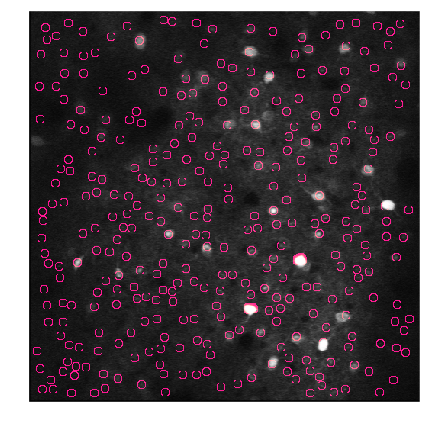

In [8]:
image(out.masks((512,512), base=ref, outline=True))

Let's see how well it did on the example data

In [9]:
recall, precision, score = sources.similarity(out, metric='distance', minDistance=5)
print('score: %.2f' % score)

score: 0.24


This algorithm isn't doing particularly well, but you *could* submit this right now to the challenge. Take the `run` function we wrote, put it in a file `run.py` in a folder called `run`, and add an empty `__init__.py` file in the same folder. Then fork the the [neurofinder](https://github.com/CodeNeuro/neurofinder) repository on GitHub and add this folder inside `submissions`. See [here](http://neurofinder.codeneuro.org/leaderboard/#submit) for more detailed instructions.

## Tweaking a built-in algorithm

Let's try to improve the algorithm a bit. One option is to use the same algorithm, but just tweak the parameters. We can inspect the algorithm we used with `?` to see all the available parameters.

In [10]:
from thunder.extraction.feature.methods.localmax import LocalMaxFeatureAlgorithm
LocalMaxFeatureAlgorithm?

Try increasing the maximum number of sources, and decrease the minimum distance

In [11]:
def run(data, info):
    
    from thunder import SourceExtraction
    method = SourceExtraction('localmax', maxSources=500, minDistance=5)
    result = method.fit(data)
    
    return result

In [12]:
out = run(images, info)

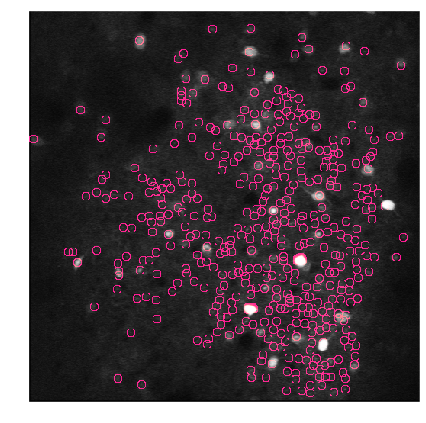

In [13]:
image(out.masks((512,512), base=ref, outline=True))

In [14]:
recall, precision, score = sources.similarity(out, metric='distance', minDistance=5)
print('score: %.2f' % score)

score: 0.27


Hmm, that did a bit better, but still not great. Note that the precision (the number of extra sources the algorithm found) is particularly bad.

In [15]:
print('precision: %.2f' % precision)

precision: 0.23


You probably don't want to submit this one, but using and tweaking the existing algorithms is a perfectly valid way to submit algorithms! You might end up with something that works really well.

## Trying a different algorithm class

Most likely the algorithm about just isn't the right algorithm for these data. Let's try a `block` algorithm, which does more complex spatio-temporal feature extraction on sub-regions, or blocks, of the full movie

In [ ]:
def run(data, info):

    from thunder import SourceExtraction
    from thunder.extraction import OverlapBlockMerger
    merger = OverlapBlockMerger(0.1)
    method = SourceExtraction('nmf', merger=merger, componentsPerBlock=5, percentile=95, minArea=100, maxArea=500)
    result = method.fit(data, size=(32, 32), padding=8)
    
    return result 

Let's run this algorithm. It'll take a little longer because it's more complex, that's one of the reasons we try to parallelize these computations!

In [ ]:
out = run(images, info)

Inspect the result

In [ ]:
image(out.masks((512,512), base=ref, outline=True))

In [ ]:
recall, precision, score = sources.similarity(out, metric='distance', minDistance=5)
print('score: %.2f' % score)

The overall score is worse, but note that the precision is incredibly high. We missed a lot of sources, but the ones we found are all good. You can see that in the image above: every identified region does indeed look like it found a neuron.

In [ ]:
print('precision: %.2f' % precision)

## Writing a custom block algorithm

For our final example, we'll build a custom algorithm from strach using the constructors from `Thunder`. First, we'll define a function to run on each block. For testing and debugging our function, we'll grab a single block. We'll pick one with a large total standard deviation (in both space and time), so it's likely to have some structure. 

In [ ]:
b = images.toBlocks(size=(40,40)).values().filter(lambda x: x.std() > 1000).first()

This should be a single `numpy` array with shape `(100,40,40)`, corresponding to the dimensions in time and space.

In [ ]:
b.shape

Let's write a function that computes the standard deviation over time, finds the index of the max, draws a circle around the peak, and returns it as a `Source`.

In [ ]:
def stdpeak(block):

    # compute the standard deviation over time
    s = block.std(axis=0)
    
    # get the indices of the peak
    from numpy import where
    r, c = where(s == s.max())
    
    # define a circle around the center, clipping at the boundaries
    from skimage.draw import circle
    rr, cc = circle(r[0], c[0], 10, shape=block.shape[1:])
    coords = zip(rr, cc)

    # return as a list of sources (in this case it's just one)\n",
    from thunder.extraction.source import Source
    if len(coords) > 0:
        return [Source(coords)]
    else:
        return []

Test that our function does something reasonable on the test block, showing the recovered source and the mean of the block over time side by side

In [ ]:
s = stdpeak(b)
tile([s[0].mask((40,40)), b.std(axis=0)])

Now we can build a block method that uses this function. We just need to import the classes for constructing block methods, and define an `extract` function to run on each block. In this case, we'll just call our `stdpeak` function from above, but to form a complete submission you'd need to include this function alongside `run`. See the inline comments for what we're doing at each step.

In [ ]:
def run(data, info):

    # import the classes we need for construction
    from thunder.extraction.block.base import BlockAlgorithm, BlockMethod
    
    # create a custom class by extending the base method
    class TestBlockAlgorithm(BlockAlgorithm):
        
        # write an extract function which draws a circle around the pixel 
        # in each block with peak standard deviation
        def extract(self, block):
            return stdpeak(block)
    
    # now instaitiate our new method and use it to fit the data
    method = BlockMethod(algorithm=TestBlockAlgorithm())
    result = method.fit(data, size=(40, 40))
    
    return result 

Now run and evaluate the algorithm

In [ ]:
out = run(images, info) 

In [ ]:
image(out.masks((512,512), base=sources, outline=True))

In [ ]:
recall, precision, score = sources.similarity(out, metric='distance', minDistance=5)
print('score: %.2f' % score)

Performance is poor, but this isn't a particularly good algorithm! Our goal was just demonstrating the API. If you made it this far, you're definitely ready to write your own algorithm. **Go forth and find all the neurons!**